# 线性支持向量机的朴素实现

+ 虽然从形式上来说，线性支持向量机（LinearSVM）和感知机的差别只在于损失函数，但如果只是简单地将感知机的训练策略（亦即每次只选出使得损失函数最大的样本点来进行梯度下降）迁移过来的话、会引发一些问题。为方便，我们称感知机的训练策略为`极大梯度下降法`（注：这不是被广泛承认的称谓，只是本文的一个代称）
+ 我们会先展示极大梯度下降法的有效性，然后会展示极大梯度下降法存在的问题，最后则会介绍一种解决方案、并将该解决方案拓展为 Mini-Batch 梯度下降法（MBGD）

## 极大梯度下降法训练 LinearSVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class LinearSVM:
    def __init__(self):
        self._w = self._b = None
        
    def fit(self, x, y, c=1, lr=0.01, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        self._w = np.zeros(x.shape[1])
        self._b = 0.
        for _ in range(epoch):
            self._w *= 1 - lr
            err = 1 - y * self.predict(x, True)
            idx = np.argmax(err)
            # 注意即使所有 x, y 都满足 w·x + b >= 1
            # 由于损失里面有一个 w 的模长平方
            # 所以仍然不能终止训练，只能截断当前的梯度下降
            if err[idx] <= 0:
                continue
            delta = lr * c * y[idx]
            self._w += delta * x[idx]
            self._b += delta
    
    def predict(self, x, raw=False):
        x = np.asarray(x, np.float32)
        y_pred = x.dot(self._w) + self._b
        if raw:
            return y_pred
        return np.sign(y_pred).astype(np.float32)
    
    def genPlt(self, X, Y, plt):
        plt.plot(X[Y == 1][:,0], X[Y == 1][:,1],'bo')
        plt.plot(X[Y == -1][:,0], X[Y == -1][:,1],'r*')
        plt.plot(X[Y == 0][:,0], X[Y == 0][:,1],'g+')
        
        
        ly = np.linspace(x[:,1].min(),x[:,1].max())
        lx = -(self._b + self._w[1] * ly)/self._w[0]

        plt.plot(lx,ly)
        return plt
        

### 测试

In [2]:
def genData():
    X = np.loadtxt("cities_n.csv", delimiter=',', skiprows=1, usecols=(1, 2))
    Y = np.loadtxt("cities_n.csv", delimiter=',', skiprows=1, usecols=(3))
    
    sample1 = np.random.choice(X[Y == 1].shape[0],300)
    sample2 = np.random.choice(X[Y == -1].shape[0],300) + X[Y == 1].shape[0]
    sample = np.concatenate(([0,],np.concatenate((sample1,sample2))))
    X = X[sample].copy()
    Y= Y[sample].copy()
    
    return X,Y


(18254, 2)


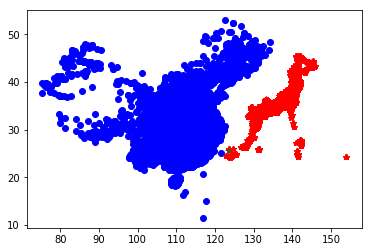

In [3]:
x = np.loadtxt("cities_all.csv", delimiter=',', skiprows=1, usecols=(1, 2))
y = np.loadtxt("cities_all.csv", delimiter=',', skiprows=1, usecols=(3))
print(x.shape)
plt.plot(x[y == 1][:,0], x[y == 1][:,1],'bo')
plt.plot(x[y == -1][:,0], x[y == -1][:,1],'r*')
plt.plot(x[y == 0][:,0], x[y == 0][:,1],'g+')

(601, 2)


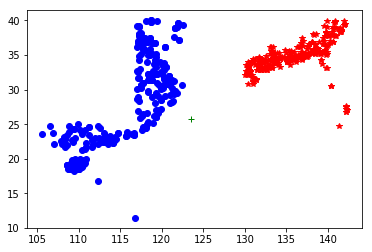

In [4]:
x, y = genData()
print(x.shape)
plt.plot(x[y == 1][:,0], x[y == 1][:,1],'bo')
plt.plot(x[y == -1][:,0], x[y == -1][:,1],'r*')
plt.plot(x[y == 0][:,0], x[y == 0][:,1],'g+')

In [65]:
svm = LinearSVM()
svm.fit(x, y)
print("准确率：{:8.6} %".format((svm.predict(x) == y).mean() * 100))

准确率：0.166389 %


/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


<module 'matplotlib.pyplot' from '/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/matplotlib/pyplot.py'>

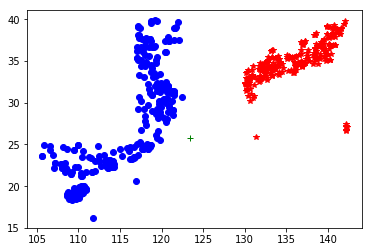

In [67]:
svm.genPlt(x,y,plt)

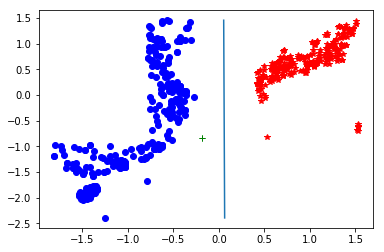

In [68]:
# 进行归一化处理
x -= x.mean(axis=0)
x /= x.std(axis=0)
# Top 1 梯度下降法即为极大梯度下降法
top_1_svm = LinearSVM()
top_1_svm.fit(x[1:], y[1:])
top_1_svm.genPlt(x,y,plt)

plt.plot(x[0][0], x[0][1],'g+')
plt.show()

## 解决方案

极大梯度下降法的最大问题很有可能在于它每次都只根据**使得损失函数最大的一个样本点**来进行梯度下降，这会导致两个问题：
+ 模型的训练将会很不稳定（这点和随机梯度下降类似）
+ 模型对噪声或“不太好的点”极为敏感（因为它们往往会使损失函数最大）

按部就班、我们先解决第一个问题，为此我们只需要多选出几个样本点（比如选出使得损失函数最大的 top n 个样本）、然后取它们梯度的平均即可

### Top n 梯度下降法

+ 注：该名字同样只是我瞎编的一个名字（喂）

In [69]:
# 继承上一个 LinearSVM 以重复利用代码
class LinearSVM2(LinearSVM):    
    # 用参数 batch_size 表示 Top n 中的 n
    def fit(self, x, y, c=1, lr=0.01, batch_size=128, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        # 如果 batch_size 设得比样本总数还多、则将其改为样本总数
        batch_size = min(batch_size, len(y))
        self._w = np.zeros(x.shape[1])
        self._b = 0.
        for _ in range(epoch):
            self._w *= 1 - lr
            err = 1 - y * self.predict(x, True)
            # 利用 argsort 函数直接取出 Top n
            # 注意 argsort 的结果是从小到大的，所以要用 [::-1] 把结果翻转一下
            batch = np.argsort(err)[-batch_size:][::-1]
            err = err[batch]
            if err[0] <= 0:
                continue
            # 注意这里我们只能利用误分类的样本做梯度下降
            # 因为被正确分类的样本处、这一部分的梯度为 0
            mask = err > 0
            batch = batch[mask]
            # 取各梯度平均并做一步梯度下降
            delta = lr * c * y[batch]
            self._w += np.mean(delta[..., None] * x[batch], axis=0)
            self._b += np.mean(delta)
            
        def genPlt(self, X, Y, plt):
            plt.plot(X[Y == 1][:,1], X[Y == 1][:,0],'bo')
            plt.plot(X[Y == -1][:,1], X[Y == -1][:,0],'r*')
            plt.plot(X[Y == 0][:,1], X[Y == 0][:,0], 'ys')

            ly = np.linspace(x[:,1].min(),x[:,1].max())
            lx = -(w[0] + w[2] * ly)/w[1]

            plt.plot(lx,ly)
            return plt

#### 测试

准确率： 99.8336 %


<module 'matplotlib.pyplot' from '/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/matplotlib/pyplot.py'>

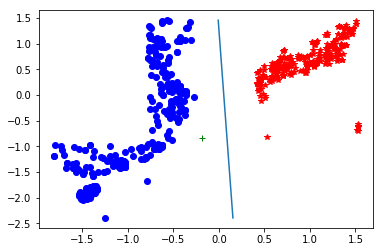

In [70]:
# x, y = gen_two_clusters(center=5, dis=1)
svm = LinearSVM2()
svm.fit(x, y)
print("准确率：{:8.6} %".format((svm.predict(x) == y).mean() * 100))
# visualize2d(svm, x, y)
# visualize2d(svm, x, y, True)
svm.genPlt(x,y,plt)

### Mini-Batch 梯度下降法（MBGD）

+ 上述解决方案已经不错，但我们还是有些太“激进”了——我们每次进行梯度下降时，选取的样本点都是使得损失函数最大的样本点，但一般而言使损失函数最大的样本点如果不是关键的样本点（支持向量）的话、通常而言会是噪声。当数据集比较差时，噪声所带来的副作用很有可能就会盖过支持向量带来的正效应
+ 为此，我们应该引入一定的随机性。神经网络的训练中所用的 MBGD 就是很好的方法：每次都从数据集中抽样出一个小 Batch，然后用这个 Batch 来做梯度下降

In [71]:
class LinearSVM3(LinearSVM):
    def fit(self, x, y, c=1, lr=0.01, batch_size=128, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        batch_size = min(batch_size, len(y))
        self._w = np.zeros(x.shape[1])
        self._b = 0.
        for _ in range(epoch):
            self._w *= 1 - lr
            # 随机选取 batch_size 个样本
            batch = np.random.choice(len(x), batch_size)
            x_batch, y_batch = x[batch], y[batch]
            err = 1 - y_batch * self.predict(x_batch, True)
            if np.max(err) <= 0:
                continue
            mask = err > 0
            delta = lr * c * y_batch[mask]
            self._w += np.mean(delta[..., None] * x_batch[mask], axis=0)
            self._b += np.mean(delta)
            
        def genPlt(self, X, Y, plt):
            plt.plot(X[Y == 1][:,1], X[Y == 1][:,0],'bo')
            plt.plot(X[Y == -1][:,1], X[Y == -1][:,0],'r*')
            plt.plot(X[Y == 0][:,1], X[Y == 0][:,0], 'ys')

            ly = np.linspace(x[:,1].min(),x[:,1].max())
            lx = -(w[0] + w[2] * ly)/w[1]

            plt.plot(lx,ly)
            return plt

#### 测试

Top n LinearSVM 准确率： 99.8336 %
MBGD  LinearSVM 准确率： 97.3378 %


<module 'matplotlib.pyplot' from '/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/matplotlib/pyplot.py'>

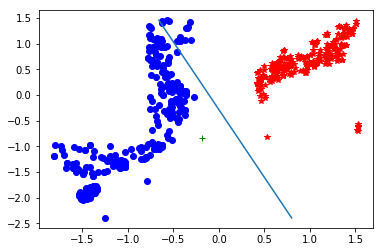

In [72]:
# 进一步拉近正负样本点间的距离以观察性能
top_n_svm = LinearSVM2()
top_n_svm.fit(x, y)
print("Top n LinearSVM 准确率：{:8.6} %".format((top_n_svm.predict(x) == y).mean() * 100))
mbgd_svm = LinearSVM3()
mbgd_svm.fit(x, y)
print("MBGD  LinearSVM 准确率：{:8.6} %".format((mbgd_svm.predict(x) == y).mean() * 100))
mbgd_svm.genPlt(x,y,plt)

## 解决方案

+ 采用更好的梯度下降法，比如`Adam`之类的
+ 进行数据预处理、把数据的 scale 弄回 1

关于`Adam`等梯度下降算法的实现和在 LinearSVM 上的应用可以参见[这里](https://github.com/carefree0910/MachineLearning/blob/master/NN/Basic/Optimizers.py)和[这里](https://github.com/carefree0910/MachineLearning/blob/master/e_SVM/LinearSVM.py)，下面我们就仅展示进行数据预处理后的结果

Top 1 LinearSVM 准确率：0.499168 %
Top n LinearSVM 准确率： 99.5008 %
MBGD  LinearSVM 准确率： 94.8419 %


/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


<module 'matplotlib.pyplot' from '/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/matplotlib/pyplot.py'>

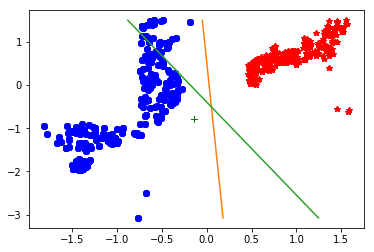

In [73]:
x, y = genData()
# 进行归一化处理
x -= x.mean(axis=0)
x /= x.std(axis=0)
# Top 1 梯度下降法即为极大梯度下降法
top_1_svm = LinearSVM()
top_1_svm.fit(x, y)
print("Top 1 LinearSVM 准确率：{:8.6} %".format((top_1_svm.predict(x) == y).mean() * 100))
top_n_svm = LinearSVM2()
top_n_svm.fit(x, y)
print("Top n LinearSVM 准确率：{:8.6} %".format((top_n_svm.predict(x) == y).mean() * 100))
mbgd_svm = LinearSVM3()
mbgd_svm.fit(x, y)
print("MBGD  LinearSVM 准确率：{:8.6} %".format((mbgd_svm.predict(x) == y).mean() * 100))

top_1_svm.genPlt(x,y,plt)
top_n_svm.genPlt(x,y,plt)
mbgd_svm.genPlt(x,y,plt)

可以看到在归一化处理后，即使是简单地采用极大梯度下降法，也能够在比较苛刻的数据（`center=5`、`dis=1`、`scale=5`）上表现得不错